Time series prediction with LSTMs

This notebook is adopted from Simple RNN DSBA applications.
Please visit the related notebook for more details.

This notebook is also adopted from [Machine Learning Mastery](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
Please visit the tutorial there for more details and to see variations of that using sliding windows and timesteps.



In [56]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [57]:
tweet = pd.read_csv('/content/drive/MyDrive/Final Project/NLP/GucciTweets.csv')
tweet = tweet[['created_at', 'Polarity']]
tweet.head()

,created_at,Polarity
0,2021-11-04 07:00:35,0.000000
1,2021-11-04 03:28:11,0.000000
2,2021-11-03 21:10:35,0.136364
3,2021-11-03 17:38:45,0.000000
4,2021-11-03 03:25:56,0.000000


In [58]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3251 entries, 0 to 3250
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   created_at  3251 non-null   object 
 1   Polarity    3251 non-null   float64
dtypes: float64(1), object(1)
memory usage: 50.9+ KB


In [59]:
tweet['created_at'] = pd.to_datetime(tweet['created_at'])
tweet['quarter'] = tweet['created_at'].dt.to_period('Q')

tweet.head()

,created_at,Polarity,quarter
0,2021-11-04 07:00:35,0.000000,2021Q4
1,2021-11-04 03:28:11,0.000000,2021Q4
2,2021-11-03 21:10:35,0.136364,2021Q4
3,2021-11-03 17:38:45,0.000000,2021Q4
4,2021-11-03 03:25:56,0.000000,2021Q4


In [60]:
tweet.drop(columns='created_at', axis=1, inplace=True)
tweet = tweet.groupby(tweet['quarter']).mean()

tweet.head()

,Polarity
quarter,
2018Q4,0.093938
2019Q1,0.114935
2019Q2,0.078449
2019Q3,0.117100
2019Q4,0.107831


In [61]:
tweet.reset_index(inplace=True)

tweet.head()

,quarter,Polarity
0,2018Q4,0.093938
1,2019Q1,0.114935
2,2019Q2,0.078449
3,2019Q3,0.117100
4,2019Q4,0.107831


In [62]:
tweet.shape

(13, 2)

In [63]:
import numpy
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [64]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [65]:
# normalizing
scaler = MinMaxScaler(feature_range=(0, 1))
tweet['Polarity_scaled'] = scaler.fit_transform(tweet['Polarity'].values.reshape(-1, 1))

In [66]:
# create targets by shifting
tweet['Polarity+1'] = tweet.Polarity_scaled.shift(-1, fill_value=tweet.Polarity_scaled.iloc[-1])

In [67]:
tweet

,quarter,Polarity,Polarity_scaled,Polarity+1
0,2018Q4,0.093938,0.128459,0.302606
1,2019Q1,0.114935,0.302606,0.000000
2,2019Q2,0.078449,0.000000,0.320560
3,2019Q3,0.117100,0.320560,0.243684
4,2019Q4,0.107831,0.243684,0.095467
5,2020Q1,0.089960,0.095467,0.475983
6,2020Q2,0.135840,0.475983,0.389665
7,2020Q3,0.125432,0.389665,0.115209
8,2020Q4,0.092340,0.115209,0.798029
9,2021Q1,0.174670,0.798029,1.000000


In [68]:
# get the data as matrix
tweet_p = tweet.iloc[:,2:].values.astype('float32')

In [69]:
# split into train and test sets
train_size = int(len(tweet_p) * 0.67)
test_size = len(tweet_p) - train_size
train, test = tweet_p[0:train_size,:], tweet_p[train_size:len(tweet_p),:]
print(len(train), len(test))

8 5


In [70]:
X_train = train[:,0]
y_train = train[:,1]

X_test = test[:,0]
y_test = test[:,1]

In [71]:
# reshape input to be [samples, time steps, features]
X_train = numpy.reshape(X_train, (X_train.shape[0], 1, 1))
X_test = numpy.reshape(X_test, (X_test.shape[0], 1, 1))

In [72]:
# build the network

model = Sequential()
model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [73]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
8/8 - 2s - loss: 0.0705
Epoch 2/50
8/8 - 0s - loss: 0.0657
Epoch 3/50
8/8 - 0s - loss: 0.0613
Epoch 4/50
8/8 - 0s - loss: 0.0571
Epoch 5/50
8/8 - 0s - loss: 0.0538
Epoch 6/50
8/8 - 0s - loss: 0.0495
Epoch 7/50
8/8 - 0s - loss: 0.0469
Epoch 8/50
8/8 - 0s - loss: 0.0441
Epoch 9/50
8/8 - 0s - loss: 0.0420
Epoch 10/50
8/8 - 0s - loss: 0.0396
Epoch 11/50
8/8 - 0s - loss: 0.0370
Epoch 12/50
8/8 - 0s - loss: 0.0359
Epoch 13/50
8/8 - 0s - loss: 0.0336
Epoch 14/50
8/8 - 0s - loss: 0.0328
Epoch 15/50
8/8 - 0s - loss: 0.0315
Epoch 16/50
8/8 - 0s - loss: 0.0307
Epoch 17/50
8/8 - 0s - loss: 0.0297
Epoch 18/50
8/8 - 0s - loss: 0.0291
Epoch 19/50
8/8 - 0s - loss: 0.0285
Epoch 20/50
8/8 - 0s - loss: 0.0279
Epoch 21/50
8/8 - 0s - loss: 0.0275
Epoch 22/50
8/8 - 0s - loss: 0.0272
Epoch 23/50
8/8 - 0s - loss: 0.0269
Epoch 24/50
8/8 - 0s - loss: 0.0267
Epoch 25/50
8/8 - 0s - loss: 0.0267
Epoch 26/50
8/8 - 0s - loss: 0.0264
Epoch 27/50
8/8 - 0s - loss: 0.0261
Epoch 28/50
8/8 - 0s - loss: 0.0261
E

In [75]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [76]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])

testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [77]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.02 RMSE
Test Score: 0.05 RMSE


In [78]:
tweet['Polarity_pred'] = tweet['Polarity']

In [79]:
testPredict.shape

(5, 1)

In [80]:
tweet['Polarity_pred'].iloc[-48:] = testPredict.flatten()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


ValueError: ignored

In [81]:
tweet['Polarity_pred']

0     0.093938
1     0.114935
2     0.078449
3     0.117100
4     0.107831
5     0.089960
6     0.135840
7     0.125432
8     0.092340
9     0.174670
10    0.199022
11    0.156753
12    0.094319
Name: Polarity_pred, dtype: float64

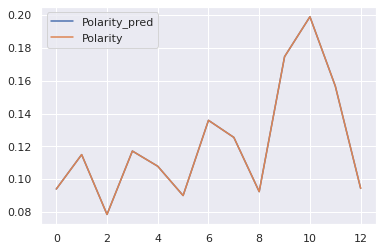

In [82]:
tweet.loc[:,['Polarity_pred','Polarity']].plot()